1. 数据处理和清理

In [19]:
import pandas as pd

# ---- 读数：按需调整 encoding / sep ----
# 常见 CSV 用逗号分隔；若你的文件是制表符分隔，改成 sep="\t"
# 若遇到编码报错，可把 encoding 改为 "utf-8-sig" 或 "gbk"
df = pd.read_csv("data.csv", sep=",", encoding="utf-8", low_memory=False)

# ---- 展示前 10 行 ----
# 在 Jupyter 下用 display 更友好；纯打印可用 print
try:
    from IPython.display import display
    display(df.head(10))
except Exception:
    print(df.head(10).to_string())

# ---- 打印列名列表 ----
print("\nColumns list:")
print(list(df.columns))


,order_book_id,date,buy_volume,buy_value,sell_volume,sell_value,pct_rate
0,688683.XSHG,2021-04-12,9488253.0,184305399.0,12568808.0,242386089.0,NaN
1,688683.XSHG,2021-04-13,5837536.0,102318291.0,7348062.0,127307478.0,-0.081540
2,688683.XSHG,2021-04-14,3412478.0,52901122.0,3812147.0,59088152.0,-0.048705
3,688683.XSHG,2021-04-15,1681787.0,25623177.0,2598894.0,39561342.0,-0.019443
4,688683.XSHG,2021-04-16,4104113.0,64973383.0,3943159.0,62451744.0,0.036352
5,688683.XSHG,2021-04-19,4010367.0,65405954.0,3464160.0,56415753.0,0.045918
6,688683.XSHG,2021-04-20,2213537.0,35760344.0,3750943.0,60472693.0,-0.031098
7,688683.XSHG,2021-04-21,1354628.0,21119249.0,2253812.0,35088166.0,-0.030208
8,688683.XSHG,2021-04-22,1022702.0,15837029.0,1102324.0,17048551.0,0.007787
9,688683.XSHG,2021-04-23,1325766.0,20751142.0,1591979.0,24891797.0,0.002576



Columns list:
['order_book_id', 'date', 'buy_volume', 'buy_value', 'sell_volume', 'sell_value', 'pct_rate']


In [ ]:
import pandas as pd

df = pd.read_csv("data.csv")

# 唯一值列表
unique_ids = df['order_book_id'].unique()

print(f"共有 {len(unique_ids)} 个唯一的 order_book_id")
print("具体列表:")
print(unique_ids)


In [ ]:
import pandas as pd

# 读取数据
df = pd.read_csv("data.csv")

# 选出这只股票的相关日期
stock = "688683.XSHG"
tmp = df[(df['order_book_id'] == stock) & 
         (df['date'].between("2021-04-21", "2021-04-22"))]

print(tmp[['date', 'pct_rate']])


3. 覆盖率与连续性检查

In [15]:
import pandas as pd

# 读取原始数据
df = pd.read_csv("data_clean.csv")
# 计算每只股票的交易日覆盖率
ticker_date_sets = df.groupby("order_book_id")["date"].apply(set)
global_date_set = set(df["date"].unique())

cover_ratio = ticker_date_sets.apply(lambda s: len(s) / len(global_date_set))

# 设定阈值，例如 90%
threshold = 0.5
bad_tickers = cover_ratio[cover_ratio < threshold].index

print("\n>>> 各股票覆盖率统计：")
print(cover_ratio.describe())

print(f"\n>>> 覆盖率低于 {threshold:.0%} 的股票数量：{len(bad_tickers)}")
# print(bad_tickers.tolist())



>>> 各股票覆盖率统计：
count    5343.000000
mean        0.872118
std         0.225515
min         0.002257
25%         0.808879
50%         0.999248
75%         1.000000
max         1.000000
Name: date, dtype: float64

>>> 覆盖率低于 50% 的股票数量：524


4. 查询源数据 ticker 日期连续情况

In [20]:
import pandas as pd

# 1) 读入与基础清洗
df = pd.read_csv("data.csv", parse_dates=["date"])
df["date"] = df["date"].dt.normalize()  # 去掉时间成分，保留日期
# 若一支股票一天有多条（比如分笔汇总），先按 (ticker, date) 去重
df = df.drop_duplicates(subset=["order_book_id", "date"])

# 2) 全局交易日并集（按数据实际出现过的日期）
master_dates = pd.Index(df["date"].sort_values().unique())

# 3) 每个 ticker 的最早/最晚日期
g = df.groupby("order_book_id")["date"]
minmax = g.agg(["min", "max"])

# 4) 逐 ticker 计算缺失天数（只在自身 [min, max] 区间内按 master_dates 检查）
rows = []
# 如需缺失日期清单，打开下面的字典收集（警惕内存）
# missing_detail = {}

for ticker, dates in g:
    dmin, dmax = minmax.loc[ticker, "min"], minmax.loc[ticker, "max"]
    expected = master_dates[(master_dates >= dmin) & (master_dates <= dmax)]
    actual = pd.Index(dates.unique())
    missing = expected.difference(actual)

    rows.append((ticker, missing.size))
    # 如需缺失日期明细，取消注释
    # if missing.size > 0:
    #     missing_detail[ticker] = missing.tolist()

res = pd.DataFrame(rows, columns=["order_book_id", "missing_count"]) \
        .sort_values("missing_count", ascending=False) \
        .reset_index(drop=True)

incomplete = (res["missing_count"] > 0).sum()

print(f"总 ticker 数: {res.shape[0]}")
print(f"数据不连续（期内有缺口）的 ticker 数: {incomplete}")
print("\n缺失天数最多的前 20 个标的：")
print(res.head(20))


总 ticker 数: 5343
数据不连续（期内有缺口）的 ticker 数: 0

缺失天数最多的前 20 个标的：
   order_book_id  missing_count
0    000001.XSHE              0
1    600707.XSHG              0
2    600705.XSHG              0
3    600704.XSHG              0
4    600703.XSHG              0
5    600702.XSHG              0
6    600701.XSHG              0
7    600699.XSHG              0
8    600698.XSHG              0
9    600697.XSHG              0
10   600696.XSHG              0
11   600695.XSHG              0
12   600694.XSHG              0
13   600693.XSHG              0
14   600692.XSHG              0
15   600691.XSHG              0
16   600690.XSHG              0
17   600689.XSHG              0
18   600688.XSHG              0
19   600706.XSHG              0


5. 清理"buy_volume", "buy_value", "sell_volume", "sell_value", "pct_rate" 任一字段为 0 的日期


In [22]:
import pandas as pd

# 读入原始数据
df = pd.read_csv("data.csv", parse_dates=["date"])
df["date"] = df["date"].dt.normalize()

# 先确保 (ticker, date) 唯一（防止重复）
df = df.drop_duplicates(subset=["order_book_id", "date"])

# 需要检查的字段
cols = ["buy_volume", "buy_value", "sell_volume", "sell_value", "pct_rate"]

# 条件：任意一个字段为 0
mask = (df[cols] == 0).any(axis=1)

# 清理：去掉满足条件的整行
df_clean = df.loc[~mask].copy()

# 保存
df_clean.to_csv("data_clean.csv", index=False)

print(f"原始数据量: {len(df)} 行")
print(f"清理后数据量: {len(df_clean)} 行")
print(f"删除比例: {100 * (1 - len(df_clean)/len(df)):.2f}%")


原始数据量: 7100847 行
清理后数据量: 6890809 行
删除比例: 2.96%


6. 计算因子

In [2]:
import pandas as pd
import numpy as np
from numba import njit

# ------------------------
# 参数
# ------------------------
W = 20          # 回溯窗口
LAMBDA = 0.2
K = max(1, int(W * LAMBDA))  # 20% -> 4

@njit
def rolling_factor_numba(pct_rate: np.ndarray, a: np.ndarray, window: int, k: int) -> np.ndarray:
    """
    对单支股票序列做滚动计算：
    - 在过去 window 天内，取 pct_rate 最低的 k 天；
    - 对这 k 天对应的 a 取平均；若这些 a 全为 NaN，则结果 NaN；
    - 窗口未满返回 NaN；
    - 窗口内 pct_rate 为 NaN 的记录不参与“最低k日”筛选（等价于窗口有效样本不足时以实际 m<k 参与）。
    """
    n = pct_rate.shape[0]
    out = np.empty(n, dtype=np.float64)
    out[:] = np.nan

    pr_buf = np.empty(window, dtype=np.float64)
    pos_buf = np.empty(window, dtype=np.int64)

    for i in range(n):
        if i < window - 1:
            continue
        start = i - window + 1

        # 收集窗口内 pct_rate 非 NaN 的值及相对位置
        m = 0
        for j in range(window):
            pr = pct_rate[start + j]
            if pr == pr:  # 非NaN
                pr_buf[m] = pr
                pos_buf[m] = j
                m += 1

        if m == 0:
            out[i] = np.nan
            continue

        kk = k if m >= k else m  # 有效样本不足k时，使用全部有效样本

        # 只做部分选择：取最小 kk 个
        idx = np.argpartition(pr_buf[:m], kk - 1)[:kk]

        s = 0.0
        cnt = 0
        for t in idx:
            pos = pos_buf[t]
            av = a[start + pos]
            if av == av:  # 非NaN
                s += av
                cnt += 1

        out[i] = (s / cnt) if cnt > 0 else np.nan

    return out

def main():
    # 读取与预处理
    df = pd.read_csv("data_clean.csv", parse_dates=["date"])
    df["date"] = df["date"].dt.normalize()
    df = df.drop_duplicates(subset=["order_book_id", "date"]).sort_values(["order_book_id", "date"])

    # a = (buy_value - sell_value) / (buy_value + sell_value), 分母为0置NaN
    denom = (df["buy_value"].astype(float) + df["sell_value"].astype(float))
    df["a"] = (df["buy_value"] - df["sell_value"]) / denom.replace(0, np.nan)

    # 分组计算 factor
    factors = []
    for _, g in df.groupby("order_book_id", sort=False):
        pr = g["pct_rate"].to_numpy(dtype=np.float64)
        av = g["a"].to_numpy(dtype=np.float64)
        fac = rolling_factor_numba(pr, av, W, K)
        factors.append(pd.Series(fac, index=g.index))

    df["factor"] = pd.concat(factors).sort_index()

    # 输出
    out_path = "data_with_factor.csv"
    df.to_csv(out_path, index=False)

    # 简要日志
    n_rows = len(df)
    n_na = df["factor"].isna().sum()
    print(f"OK -> {out_path}")
    print(f"rows: {n_rows:,}, factor NaN (前{W-1}天+无效窗口): {n_na:,}")

if __name__ == "__main__":
    main()


OK -> data_with_factor.csv
rows: 6,890,809, factor NaN (前19天+无效窗口): 955,737


In [4]:
import pandas as pd

df = pd.read_csv("data_with_factor.csv", parse_dates=["date"])
print(df.head(50))


   order_book_id       date   buy_volume     buy_value  sell_volume  \
0    000001.XSHE 2020-01-02   84209533.0  1.414344e+09   68813654.0   
1    000001.XSHE 2020-01-03   57934985.0  9.936956e+08   53684496.0   
2    000001.XSHE 2020-01-06   42854402.0  7.352786e+08   43353948.0   
3    000001.XSHE 2020-01-07   40404529.0  6.915981e+08   32456227.0   
4    000001.XSHE 2020-01-08   37420066.0  6.281692e+08   47362346.0   
5    000001.XSHE 2020-01-09   51455388.0  8.608370e+08   51708277.0   
6    000001.XSHE 2020-01-10   28376473.0  4.726706e+08   30178372.0   
7    000001.XSHE 2020-01-13   43810836.0  7.381023e+08   43402500.0   
8    000001.XSHE 2020-01-14   63265983.0  1.075991e+09   67183383.0   
9    000001.XSHE 2020-01-15   40288714.0  6.679568e+08   45655198.0   
10   000001.XSHE 2020-01-16   51100972.0  8.344616e+08   51709495.0   
11   000001.XSHE 2020-01-17   28823390.0  4.740652e+08   31720279.0   
12   000001.XSHE 2020-01-20   37583788.0  6.179717e+08   37023687.0   
13   0

补充 未来收益率

In [13]:
import pandas as pd

df = pd.read_csv("data_with_factor.csv", parse_dates=["date"])

# 确保排序
df = df.sort_values(["order_book_id", "date"])

# 未来1日收益率（shift -1）
df["fwd_ret1"] = df.groupby("order_book_id")["pct_rate"].shift(-1)

# 覆盖写回原表
df.to_csv("data_with_factor.csv", index=False)


In [15]:
import pandas as pd

df = pd.read_csv("data_with_factor.csv", parse_dates=["date"])
print(df.head(30))
# ---- 打印列名列表 ----
print("\nColumns list:")
print(list(df.columns))

   order_book_id       date   buy_volume     buy_value  sell_volume  \
0    000001.XSHE 2020-01-02   84209533.0  1.414344e+09   68813654.0   
1    000001.XSHE 2020-01-03   57934985.0  9.936956e+08   53684496.0   
2    000001.XSHE 2020-01-06   42854402.0  7.352786e+08   43353948.0   
3    000001.XSHE 2020-01-07   40404529.0  6.915981e+08   32456227.0   
4    000001.XSHE 2020-01-08   37420066.0  6.281692e+08   47362346.0   
5    000001.XSHE 2020-01-09   51455388.0  8.608370e+08   51708277.0   
6    000001.XSHE 2020-01-10   28376473.0  4.726706e+08   30178372.0   
7    000001.XSHE 2020-01-13   43810836.0  7.381023e+08   43402500.0   
8    000001.XSHE 2020-01-14   63265983.0  1.075991e+09   67183383.0   
9    000001.XSHE 2020-01-15   40288714.0  6.679568e+08   45655198.0   
10   000001.XSHE 2020-01-16   51100972.0  8.344616e+08   51709495.0   
11   000001.XSHE 2020-01-17   28823390.0  4.740652e+08   31720279.0   
12   000001.XSHE 2020-01-20   37583788.0  6.179717e+08   37023687.0   
13   0

逐日计算 Spearman IC（更稳健）并给出汇总指标：均值、标准差、t 值、ICIR、IC>0 占比；

画出 IC 时间序列曲线（附滚动均值，便于观察稳定性）。

== IC 汇总（方法：spearman）==
N_days             1309.000000
IC_mean              -0.020360
IC_std                0.096336
t_stat               -7.646464
ICIR                 -0.211344
Pos_ratio(IC>0)       0.418640
dtype: float64


/var/folders/8f/w3_tntg17yx372z16y950kx00000gn/T/ipykernel_18600/1033111025.py:34: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_daily_ic)


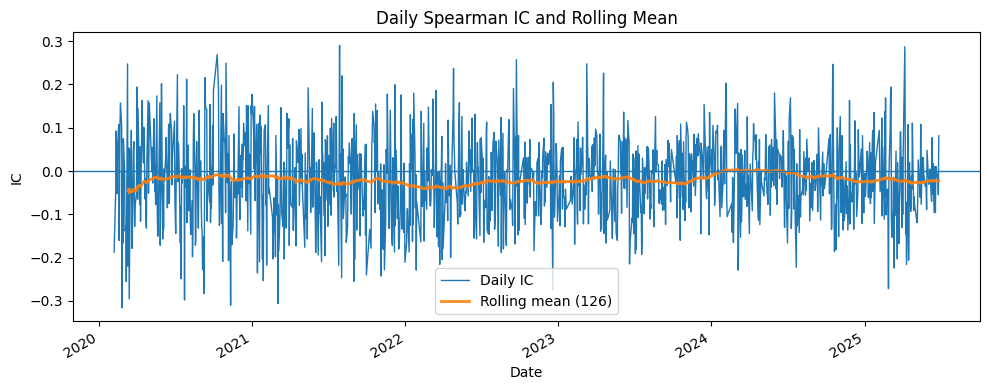

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# 可配置参数
# -------------------------
CSV_PATH = "data_with_factor.csv"
DATE_COL = "date"
FACTOR_COL = "factor"
RET_COL = "fwd_ret1"
METHOD = "spearman"   # 可选: "spearman" 或 "pearson"
ROLL_WIN = 126        # 滚动均值窗口（交易日），用于画图

# -------------------------
# 1) 读取与准备
# -------------------------
df = pd.read_csv(CSV_PATH, parse_dates=[DATE_COL])

# 确保同日内数据齐全
df = df.dropna(subset=[FACTOR_COL, RET_COL])

# -------------------------
# 2) 逐日计算 IC（横截面相关）
# -------------------------
def _daily_ic(g: pd.DataFrame) -> float:
    # 若当日有效样本过少，返回 NaN
    if g[FACTOR_COL].count() < 3 or g[RET_COL].count() < 3:
        return np.nan
    return g[FACTOR_COL].corr(g[RET_COL], method=METHOD)

ic_series = (
    df.groupby(DATE_COL, sort=True)
      .apply(_daily_ic)
      .rename(f"IC_{METHOD}")
      .astype(float)
)

# -------------------------
# 3) 汇总指标
# -------------------------
ic = ic_series.dropna()
n_days = ic.shape[0]
ic_mean = ic.mean()
ic_std = ic.std(ddof=1)
se = ic_std / np.sqrt(n_days) if n_days > 0 else np.nan
t_stat = ic_mean / se if se and se > 0 else np.nan
icir = ic_mean / ic_std if ic_std and ic_std > 0 else np.nan
pos_ratio = (ic > 0).mean() if n_days > 0 else np.nan

summary = pd.Series({
    "N_days": n_days,
    "IC_mean": ic_mean,
    "IC_std": ic_std,
    "t_stat": t_stat,
    "ICIR": icir,
    "Pos_ratio(IC>0)": pos_ratio
})

print("== IC 汇总（方法：{}）==".format(METHOD))
print(summary.round(6))

# 如需保存结果到 CSV（可选）
# ic_series.to_frame().to_csv("ic_series.csv", index=True)
# summary.to_frame("value").to_csv("ic_summary.csv")

# -------------------------
# 4) 画图：IC_t 时间序列 + 滚动均值
# -------------------------
plt.figure(figsize=(10, 4))
ic_series.plot(linewidth=1, label="Daily IC")
if ROLL_WIN and ROLL_WIN > 1:
    ic_series.rolling(ROLL_WIN, min_periods=max(5, ROLL_WIN//5)).mean().plot(
        linewidth=2, alpha=0.9, label=f"Rolling mean ({ROLL_WIN})"
    )
plt.axhline(0.0, linewidth=1)
plt.title(f"Daily {METHOD.capitalize()} IC and Rolling Mean")
plt.xlabel("Date")
plt.ylabel("IC")
plt.legend()
plt.tight_layout()
plt.show()


分组收益

分组收益（首几行预览）：
                  Q1        Q2        Q3        Q4        Q5        LS
date                                                                  
2020-02-06  0.012999  0.017889  0.011364  0.003796  0.001539 -0.011460
2020-02-07  0.020650  0.014022  0.013862  0.010209  0.008127 -0.012523
2020-02-10 -0.003552 -0.004918 -0.008854 -0.005440 -0.005523 -0.001971
2020-02-11  0.014173  0.012721  0.017679  0.018990  0.019192  0.005019
2020-02-12 -0.008676 -0.010171 -0.009396 -0.009741 -0.009722 -0.001046


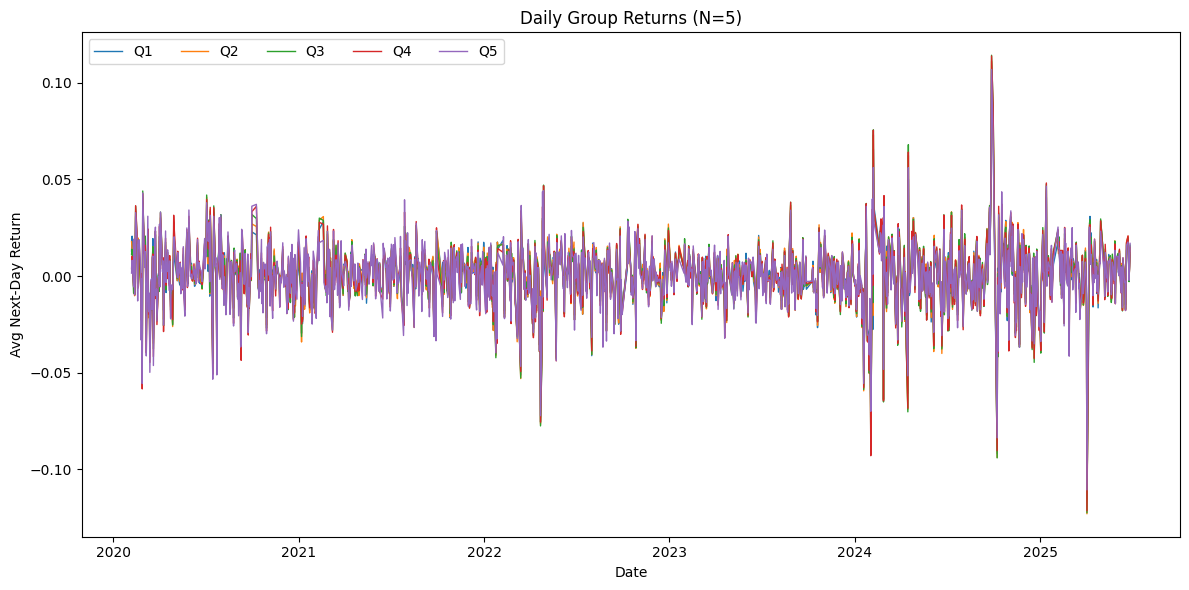

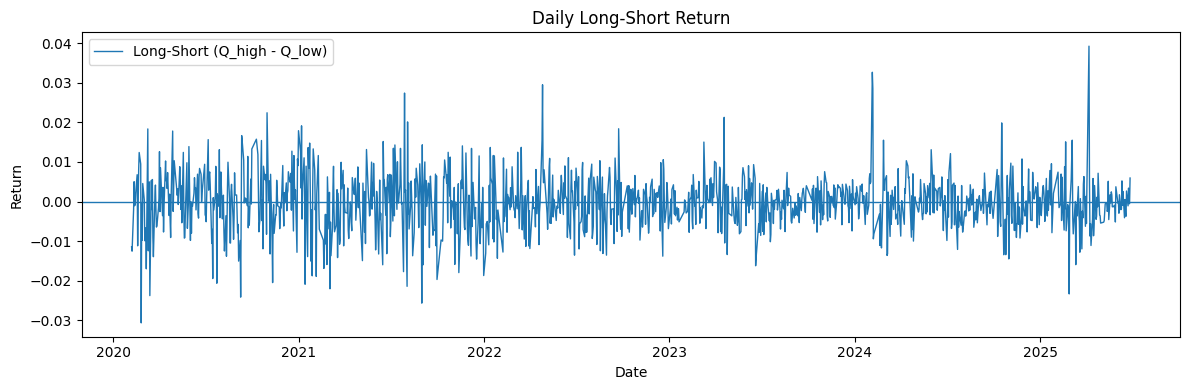

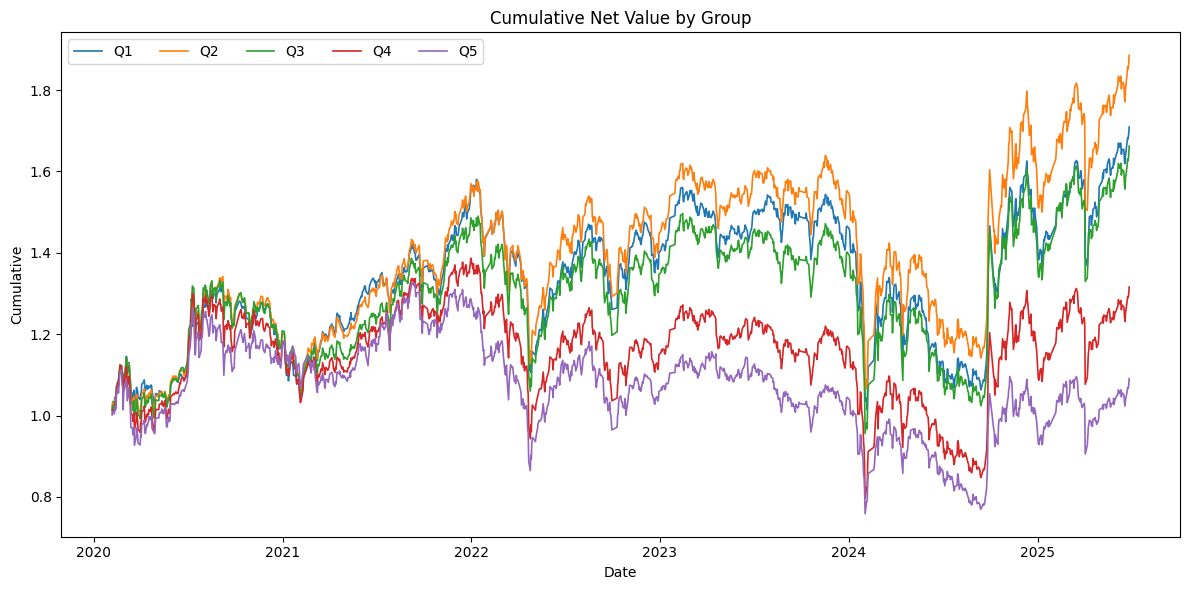

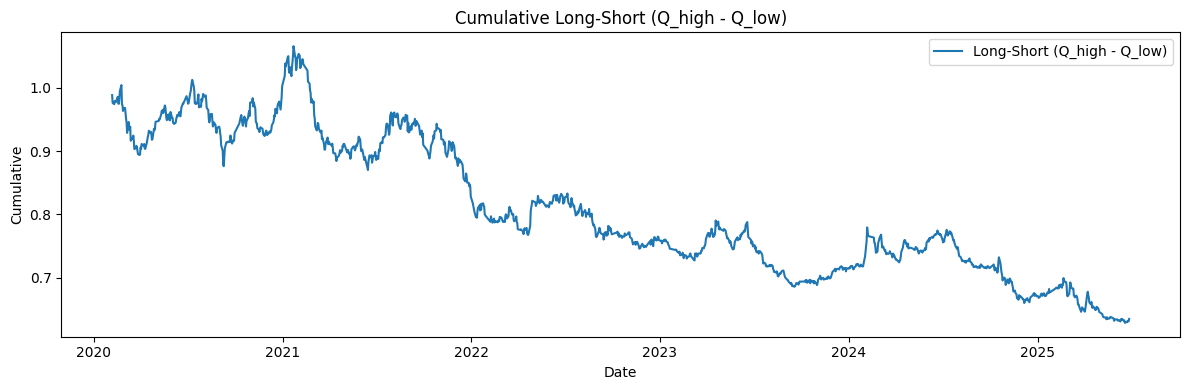

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

CSV_PATH = "data_with_factor.csv"
N_GROUPS = 5           # 分组数：5或10
MIN_STOCKS_PER_DAY = 20  # 当日最少样本数阈值（防止样本太少导致噪音）

df = pd.read_csv(CSV_PATH, parse_dates=["date"])

# 仅保留当天有因子且有次日收益的记录
df = df.dropna(subset=["factor", "fwd_ret1"])

daily_group_ret = []   # 存每个交易日各组的平均收益
dates_kept = []        # 记录保留的交易日

for date, g in df.groupby("date", sort=True):
    g = g.copy()

    # 若当日样本太少，跳过
    if len(g) < MIN_STOCKS_PER_DAY:
        continue

    # 计算因子的秩百分位（并列用 'first' 保证可重复性）
    # pct=True -> 0~1 之间
    rank_pct = g["factor"].rank(method="first", pct=True)

    # 将百分位切到 N 组：1..N_GROUPS
    grp = np.ceil(rank_pct * N_GROUPS).astype(int)
    grp = np.clip(grp, 1, N_GROUPS)
    g["group"] = grp

    # 逐组计算“次日收益”的等权平均
    gr = g.groupby("group")["fwd_ret1"].mean()

    # 若某些组在该日没有股票，补 NaN（保持列齐全）
    gr = gr.reindex(range(1, N_GROUPS+1), fill_value=np.nan)

    gr["date"] = date
    daily_group_ret.append(gr)
    dates_kept.append(date)

# 拼接为时间序列 DataFrame：index=日期，列=1..N_GROUPS
group_returns = pd.DataFrame(daily_group_ret).set_index("date").sort_index()
group_returns.columns = [f"Q{c}" if isinstance(c, (int, np.integer)) else c for c in group_returns.columns]

# （可选）构造多空：最高组 - 最低组
long_short = group_returns[f"Q{N_GROUPS}"] - group_returns["Q1"]
group_returns["LS"] = long_short

print("分组收益（首几行预览）：")
print(group_returns.head())

# ---------- 画“每日分组收益时序图” ----------
plt.figure(figsize=(12, 6))
for q in [f"Q{i}" for i in range(1, N_GROUPS+1)]:
    plt.plot(group_returns.index, group_returns[q], label=q, linewidth=1)
plt.title(f"Daily Group Returns (N={N_GROUPS})")
plt.xlabel("Date"); plt.ylabel("Avg Next-Day Return")
plt.legend(ncol=min(N_GROUPS, 6))
plt.tight_layout()
plt.show()



# （可选）画累计净值（更直观）
cum = (1 + group_returns[[f"Q{i}" for i in range(1, N_GROUPS+1)]].fillna(0)).cumprod()
ls_cum = (1 + group_returns["LS"].fillna(0)).cumprod()

plt.figure(figsize=(12, 6))
for q in cum.columns:
    plt.plot(cum.index, cum[q], label=q, linewidth=1.2)
plt.title("Cumulative Net Value by Group")
plt.xlabel("Date"); plt.ylabel("Cumulative")
plt.legend(ncol=min(N_GROUPS, 6))
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(ls_cum.index, ls_cum, label="Long-Short (Q_high - Q_low)", linewidth=1.5)
plt.title("Cumulative Long-Short (Q_high - Q_low)")
plt.xlabel("Date"); plt.ylabel("Cumulative")
plt.legend()
plt.tight_layout()
plt.show()
